In [ ]:
import json
import string
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import re
import nltk
import pip
from nltk import collections
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, metrics
from sklearn.metrics import precision_recall_fscore_support
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from keras.models import Sequential
from keras import layers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, GRU, TimeDistributed, Bidirectional
from keras import backend as K
from google.colab import drive
drive.mount('/content/drive')

import requests, zipfile, io
zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

zip_file_url2 = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
r2 = requests.get(zip_file_url2)
z2 = zipfile.ZipFile(io.BytesIO(r2.content))
z2.extractall()

Mounted at /content/drive


In [ ]:
def process_data(read_data_filepath, read_label_filepath):
  label_map = {'non-rumour': 0, 'rumour': 1}
  index_map = {v: k for k, v in label_map.items()}
  with open(read_data_filepath, 'r') as f:
    source_id = []
    text = []
    label = [] 
    for line in f:
      line = json.loads(line)
      source_id.append(line[0]['id_str'])
      text.append(line[0]['text'])
    df_data = pd.DataFrame({'id':source_id,'text':text, 'label':None})
  if read_label_filepath is not None:
    with open(read_label_filepath, 'r') as f:
      id, label = [], []
      temp = json.loads(f.read())
      for key, val in temp.items():
        id.append(key)
        label.append(val)
      # label_data = pd.DataFrame(list(zip(id, label)))
      # label_data.columns = ['id', 'label']
      for i in range(len(label)):
          label[i] = 1 if label[i] == "rumour" else 0 #convert_label(label_data["label"][i])
          if source_id[i] == id[i]:
            df_data.label[i] = label[i]
    return df_data
  else:
    return df_data[['id', 'text']]

df_dev = process_data('/content/drive/My Drive/data/dev.data.jsonl', '/content/drive/My Drive/data/dev.label.json')
df_train = process_data('/content/drive/My Drive/data/train.data.jsonl', '/content/drive/My Drive/data/train.label.json')
df_test = process_data('/content/drive/My Drive/data/test.data.jsonl', None)

# a list of events, and each event is a list of tweets (source tweet + reactions)
print("Number of train data =", len(df_train["text"]))
print("Number of dev data =", len(df_dev["text"]))
print("Number of test data =", len(df_test["text"]))

Number of train data = 4641
Number of dev data = 580
Number of test data = 581


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# clean data
default_stopwords = set(nltk.corpus.stopwords.words('english'))
# will have to add the following custom
custom_stopwords = {"http://", "rt", "co", "https://", "www", "@"}
all_stopwords = default_stopwords | custom_stopwords
eng_stemmer = nltk.stem.SnowballStemmer('english')
tt = TweetTokenizer()
lemmatizer = WordNetLemmatizer()


def preprocess_data(df):
    print("Started preprocessing!")
    text = df['text'].apply(str)
    for i in range(len(text)):
        text[i] = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', text[i])
        text[i] = re.sub(r'@[^\s]+', '', text[i])
        text[i] = tt.tokenize(text[i])
        # remove single character words
        text[i] = [word for word in text[i] if len(word) > 1]
        # convert to lower case
        text[i] = [word.lower() for word in text[i]]
        # removing numbers
        text[i] = [word for word in text[i] if word.isalpha()]
        # stem the words
        text[i] = [lemmatizer.lemmatize(word) for word in text[i]]
        # remove stopwords
        text[i] = [word for word in text[i] if word not in default_stopwords]
        text[i] = " ".join(text[i])
        df['text'][i] = text[i]
    return df['text']


train_texts = preprocess_data(df_train)
dev_texts = preprocess_data(df_dev)
test_texts = preprocess_data(df_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Started preprocessing!
Started preprocessing!
Started preprocessing!


In [ ]:
test_texts[9]

'germanwings plane crash southern france french prime minister say soon'

In [ ]:
## Get Train data and Validation data for model 1
# x_train, x_test, y_train, y_test = train_test_split(train_texts, np.array(df_train["label"], dtype=int), test_size=0.1)
x_train = train_texts
y_train = np.array(df_train["label"].apply(int))
x_dev = dev_texts
y_dev = np.array(df_dev["label"].apply(int))
x_test = test_texts

In [ ]:
def convert_label_tofile(label):
    if int(label) == 1:
        label = "rumour"
        return label
    else:
        label = "non-rumour"
        return label


def write_pred(id, labels, filename):
    for i in range(len(labels)):
        labels[i][0] = convert_label_tofile(labels[i][0])
    dic = collections.OrderedDict()
    for i in range(len(id)):
        dic[id[i]] = labels[i][0]
    with open(filename, 'w') as f:
        json.dump(dic, f)
    print("save finished")


def convert_prob(y_pred):
    for i in range(len(y_pred)):
        if y_pred[i] > 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


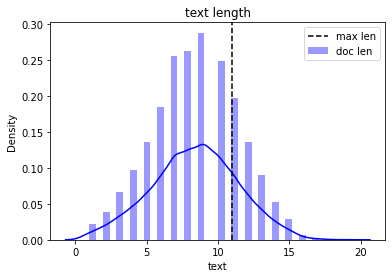

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

doc_len = x_train.apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(doc_len.mean() + doc_len.std()).astype(int)

sns.distplot(doc_len, hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('text length'); plt.legend()
plt.show()

In [ ]:
MAX_NB_WORDS = 100000
print("tokenizing input data...")
tokenizer = Tokenizer(oov_token="<UNK>", num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(x_train)
#leaky
xseq_train = tokenizer.texts_to_sequences(x_train)
xseq_dev = tokenizer.texts_to_sequences(x_dev)
xseq_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

# vocab_size = 46660
#pad sequences
xseq_train = pad_sequences(xseq_train, padding='post', maxlen=max_seq_len)
xseq_dev = pad_sequences(xseq_dev, padding='post', maxlen=max_seq_len)
xseq_test = pad_sequences(xseq_test, padding='post', maxlen=max_seq_len)

# embedding_dim = 10

tokenizing input data...
dictionary size:  5085


In [ ]:
# """
# LSTM
# """
# # word order preserved with this architecture
# model3 = Sequential(name="lstm")
# model3.add(layers.Embedding(input_dim=vocab_size,
#                             output_dim=embedding_dim,
#                             input_length=maxlen))
# model3.add(LSTM(10))
# model3.add(layers.Dense(1, activation='sigmoid'))
# model3.compile(optimizer='adam',
#                loss='binary_crossentropy',
#                metrics=['acc', f1_m, precision_m, recall_m])
# model3.summary()

# # training
# model3.fit(xseq_train, y_train, epochs=8, verbose=True, validation_data=(xseq_dev, y_dev), batch_size=10)
# loss, accuracy, f1_score, precision, recall = model3.evaluate(xseq_dev, y_dev, verbose=False)
# print("\nTesting LSTM f1_score:  {:.4f}".format(f1_score))

# # predict test set
# y_pred_test3 = model3.predict(xseq_test)
# y_pred_test3 = convert_prob(y_pred_test3)
# y_pred_test3 = np.array(y_pred_test3).tolist()
# write_pred(df_test["id"], y_pred_test3, "test-output.json")

In [ ]:
# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

keras.backend.clear_session()

In [ ]:
#Shape and Train with LSTM
#training params
batch_size = 256 
num_epochs = 40

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [ ]:
#embedding matrix
import os, re, csv, math, codecs

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8')

from tqdm import tqdm
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

999it [00:00, 9987.63it/s]

preparing embedding matrix...
loading word embeddings...


999995it [01:47, 9294.55it/s]

found 999995 word vectors
number of null word embeddings: 227


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['brinsolaro' 'haron' 'barcroft' 'monis' 'banjarnegara' 'gunm' 'kouachi'
 'phorphet' 'norad' 'florissant']


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words, embed_dim, input_length=max_seq_len, weights=[embedding_matrix], trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 300)           1525800   
_________________________________________________________________
dropout (Dropout)            (None, 11, 300)           0         
_________________________________________________________________
dense (Dense)                (None, 11, 32)            9632      
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 11, 128)           98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 11, 128)           98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 11, 128)           9

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
# training
model.fit(xseq_train, y_train, epochs=num_epochs, verbose=True, validation_data=(xseq_dev, y_dev), batch_size=256)
loss, accuracy, f1_score, precision, recall = model.evaluate(xseq_dev, y_dev, verbose=False)
print("\nTesting word sequence f1_score:  {:.4f}".format(f1_score))

Epoch 1/40
19/19 [==============================] - 27s 568ms/step - loss: 0.6671 - accuracy: 0.6429 - f1_m: 0.0257 - precision_m: 0.0579 - recall_m: 0.0165 - val_loss: 0.6014 - val_accuracy: 0.6776 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/40
19/19 [==============================] - 6s 322ms/step - loss: 0.5529 - accuracy: 0.7087 - f1_m: 0.3303 - precision_m: 0.4919 - recall_m: 0.3240 - val_loss: 0.4386 - val_accuracy: 0.7828 - val_f1_m: 0.6627 - val_precision_m: 0.6020 - val_recall_m: 0.7406
Epoch 3/40
19/19 [==============================] - 6s 318ms/step - loss: 0.4547 - accuracy: 0.7878 - f1_m: 0.6982 - precision_m: 0.6863 - recall_m: 0.7143 - val_loss: 0.4159 - val_accuracy: 0.7948 - val_f1_m: 0.6834 - val_precision_m: 0.6169 - val_recall_m: 0.7684
Epoch 4/40
19/19 [==============================] - 6s 319ms/step - loss: 0.4476 - accuracy: 0.7936 - f1_m: 0.7105 - precision_m: 0.6925 - recall_m: 0.7445 - val_loss: 0.4441 - val_accuracy

In [ ]:
y_pred_test = model.predict_classes(xseq_test)
y_pred_test = convert_prob(y_pred_test)
y_pred_test = np.array(y_pred_test).tolist()
write_pred(df_test["id"], y_pred_test, "test-cnn-0,7423.json")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


save finished


In [ ]:
"""
GRU using wiki
"""
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(GRU(256, dropout=0.2, recurrent_dropout=0.1, return_sequences=True)))
model.add(Bidirectional(GRU(256, dropout=0.2, recurrent_dropout=0.1)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 300)           1525800   
_________________________________________________________________
bidirectional (Bidirectional (None, 11, 512)           857088    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1182720   
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 3,566,121
Trainable params: 2,040,321
Non-trainable params: 1,525,800
_________________________________________________________________


In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

In [ ]:
# training
model.fit(xseq_train, y_train, epochs=num_epochs, verbose=True, validation_data=(xseq_dev, y_dev), batch_size=256)
loss, accuracy, f1_score, precision, recall = model.evaluate(xseq_dev, y_dev, verbose=False)
print("\nTesting word sequence f1_score:  {:.4f}".format(f1_score))

Epoch 1/40
19/19 [==============================] - 39s 1s/step - loss: 0.6053 - accuracy: 0.6404 - f1_m: 0.2993 - precision_m: 0.3760 - recall_m: 0.3434 - val_loss: 0.3990 - val_accuracy: 0.8241 - val_f1_m: 0.6561 - val_precision_m: 0.7143 - val_recall_m: 0.6115
Epoch 2/40
19/19 [==============================] - 24s 1s/step - loss: 0.4176 - accuracy: 0.8028 - f1_m: 0.6874 - precision_m: 0.7456 - recall_m: 0.6483 - val_loss: 0.3773 - val_accuracy: 0.8259 - val_f1_m: 0.6943 - val_precision_m: 0.7179 - val_recall_m: 0.6819
Epoch 3/40
19/19 [==============================] - 25s 1s/step - loss: 0.3887 - accuracy: 0.8240 - f1_m: 0.7333 - precision_m: 0.7576 - recall_m: 0.7140 - val_loss: 0.3679 - val_accuracy: 0.8345 - val_f1_m: 0.6963 - val_precision_m: 0.7474 - val_recall_m: 0.6615
Epoch 4/40
19/19 [==============================] - 24s 1s/step - loss: 0.3782 - accuracy: 0.8352 - f1_m: 0.7572 - precision_m: 0.7719 - recall_m: 0.7557 - val_loss: 0.3714 - val_accuracy: 0.8310 - val_f1_m: 

In [ ]:
y_pred_test = model.predict_classes(xseq_test)
y_pred_test = convert_prob(y_pred_test)
y_pred_test = np.array(y_pred_test).tolist()
write_pred(df_test["id"], y_pred_test, "test-lstm-0,7768.json")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


save finished


In [ ]:
"""
CNN+RNN 串联
"""
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix], trainable=False))
model.add(Convolution1D(256, 3, padding='same', strides = 1))
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=2))
model.add(GRU(256, dropout=0.2, recurrent_dropout=0.1, return_sequences = True))
model.add(GRU(256, dropout=0.2, recurrent_dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

# training
model.fit(xseq_train, y_train, epochs=num_epochs, verbose=True, validation_data=(xseq_dev, y_dev), batch_size=256)
loss, accuracy, f1_score, precision, recall = model.evaluate(xseq_dev, y_dev, verbose=False)
print("\nTesting word sequence f1_score:  {:.4f}".format(f1_score))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 11, 300)           1525800   
_________________________________________________________________
conv1d (Conv1D)              (None, 11, 256)           230656    
_________________________________________________________________
activation (Activation)      (None, 11, 256)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 256)            0         
_________________________________________________________________
gru (GRU)                    (None, 5, 256)            394752    
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               394752    
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [ ]:
y_pred_test = model.predict(xseq_test)
y_pred_test = convert_prob(y_pred_test)
y_pred_test = np.array(y_pred_test).tolist()
write_pred(df_test["id"], y_pred_test, "test-cnn+rnn.json")

save finished


In [ ]:
# y_labels = pd.DataFrame(y_train)
# y_labels = list(y_labels.value_counts().index)
# num_labels = len(y_labels)

In [ ]:
"""
CNN+RNN 并联
"""
# we don't want the model to overwrite, dont we?
keras.backend.clear_session()

# y_labels = pd.Dataframe(y_train)
# y_labels = list(y_labels.value_counts().index)
# num_labels = len(y_labels)

from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Convolution1D, Flatten, Dropout, MaxPool1D, GlobalAveragePooling1D
from keras.layers import Dense, Embedding, Activation, merge, Input, Lambda, Reshape
from keras.layers.merge import concatenate
from keras.models import Sequential, Model

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

main_input = Input(shape=(11,), dtype='float64')
embed = Embedding(nb_words,embed_dim, input_length=max_seq_len, weights=[embedding_matrix], trainable=False)(main_input)
cnn = Convolution1D(256, 3, padding='same', strides = 1, activation='relu')(embed)
cnn = MaxPool1D(pool_size=4)(cnn)
cnn = Flatten()(cnn)
cnn = Dense(256)(cnn)
rnn = Bidirectional(GRU(256, dropout=0.2, recurrent_dropout=0.1))(embed)
rnn = Dense(256)(rnn)
con = concatenate([cnn,rnn], axis=-1)
main_output = Dense(1, activation='sigmoid')(con)
model = Model(inputs = main_input, outputs = main_output)
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

# training
model.fit(xseq_train, y_train, epochs=num_epochs, verbose=True, validation_data=(xseq_dev, y_dev), batch_size=256)
loss, accuracy, f1_score, precision, recall = model.evaluate(xseq_dev, y_dev, verbose=False)
print("\nTesting word sequence f1_score:  {:.4f}".format(f1_score))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 11, 300)      1525800     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 11, 256)      230656      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 2, 256)       0           conv1d[0][0]                     
______________________________________________________________________________________________

In [ ]:
y_pred_test = model.predict(xseq_test)
y_pred_test = convert_prob(y_pred_test)
y_pred_test = np.array(y_pred_test).tolist()
write_pred(df_test["id"], y_pred_test, "test-cnn rnn 并.json")

save finished


In [ ]:
#embedding matrix
import os, re, csv, math, codecs

print('loading word embeddings...')
embedding_matrix1 = np.zeros((nb_words, 200))
embeddings_index1 = {}
f = codecs.open('glove.twitter.27B.200d.txt', encoding='utf-8')

from tqdm import tqdm
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index1[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index1))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index1.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix1[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix1, axis=1) == 0))

loading word embeddings...


1193515it [01:52, 10633.60it/s]

found 1193514 word vectors
number of null word embeddings: 172


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['radicalised' 'mirontschuk' 'conjointly' 'phorphet' 'fasle'
 'ultranationalism' 'haltern' 'balkanye' 'mirontschuk' 'breivak']


In [ ]:
"""
TextCNN
"""
from keras import backend as K

main_input = Input(shape=(11,), dtype='float64')
embedder = Embedding(nb_words, 200, input_length=max_seq_len, weights=[embedding_matrix1], trainable=False)
embed = embedder(main_input)
# cnn1模块，kernel_size = 3
conv1_1 = Convolution1D(256, 3, padding='same')(embed)
bn1_1 = BatchNormalization()(conv1_1)
relu1_1 = Activation('relu')(bn1_1)
conv1_2 = Convolution1D(128, 3, padding='same')(relu1_1)
bn1_2 = BatchNormalization()(conv1_2)
relu1_2 = Activation('relu')(bn1_2)
cnn1 = MaxPool1D(pool_size=4)(relu1_2)
# cnn2模块，kernel_size = 4
conv2_1 = Convolution1D(256, 4, padding='same')(embed)
bn2_1 = BatchNormalization()(conv2_1)
relu2_1 = Activation('relu')(bn2_1)
conv2_2 = Convolution1D(128, 4, padding='same')(relu2_1)
bn2_2 = BatchNormalization()(conv2_2)
relu2_2 = Activation('relu')(bn2_2)
cnn2 = MaxPool1D(pool_size=4)(relu2_2)
# cnn3模块，kernel_size = 5
conv3_1 = Convolution1D(256, 5, padding='same')(embed)
bn3_1 = BatchNormalization()(conv3_1)
relu3_1 = Activation('relu')(bn3_1)
conv3_2 = Convolution1D(128, 5, padding='same')(relu3_1)
bn3_2 = BatchNormalization()(conv3_2)
relu3_2 = Activation('relu')(bn3_2)
cnn3 = MaxPool1D(pool_size=4)(relu3_2)
# 拼接三个模块
cnn = concatenate([cnn1,cnn2,cnn3], axis=-1)
flat = Flatten()(cnn)
drop = Dropout(0.5)(flat)
fc = Dense(512)(drop)
bn = BatchNormalization()(fc)
main_output = Dense(1, activation='sigmoid')(bn)
model = Model(inputs = main_input, outputs = main_output)
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

# training
model.fit(xseq_train, y_train, epochs=num_epochs, verbose=True, validation_data=(xseq_dev, y_dev), batch_size=256)
loss, accuracy, f1_score, precision, recall = model.evaluate(xseq_dev, y_dev, verbose=False)
print("\nTesting word sequence f1_score:  {:.4f}".format(f1_score))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 11)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 11, 200)      1017200     input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 11, 256)      153856      embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 11, 256)      205056      embedding_4[0][0]                
____________________________________________________________________________________________

In [ ]:
y_pred_test = model.predict(xseq_test)
y_pred_test = convert_prob(y_pred_test)
y_pred_test = np.array(y_pred_test).tolist()
write_pred(df_test["id"], y_pred_test, "test-textcnn.json")